In [12]:
import sys
import time
import common
import argparse
import datasets
import numpy as np
import pandas as pd
from pyDOE import lhs
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
import estimators as estimators_lib
import tensorflow as tf
import tensorflow_lattice as tfl
%matplotlib inline
%config InlineBackend.figure_format='retina'


def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)
    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset, unique_values, latin_sample):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng, dataset, unique_values, latin_sample)
    sel = cal_true_card((cols, idxs, ops, vals), table) / float(table.cardinality)
    return cols, idxs, ops, vals, sel


def SampleTupleThenRandom(table, num_filters, rng, dataset, unique_values, latin_sample):
    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)
    cols = np.take(table.columns, idxs)
    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    #ops = rng.choice(['='], size=num_filters)
    #ops = rng.choice(['<=', '>=', '>', '<'], size=num_filters)
    #ops = rng.choice(['<=', '>='], size=num_filters)
    ops = rng.choice(['<='], size=num_filters)
    #ops_all_eqs = ['='] * num_filters
    #sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    #ops = np.where(sensible_to_do_range, ops, ops_all_eqs)
    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals
    if latin_sample:
        vals = [np.random.choice(unique_values[i], size=1)[0] for i in idxs]
    else:
        vals = []
        new_table = table.data
        s = new_table.iloc[rng.randint(0, new_table.shape[0])]
        vals = s.values
        vals = vals[idxs]
    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])
    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values


def dictionary_column_interval(query_set):
    # Traverse all queries to apply the intervalization skill for each column
    column_interval = {}
    for i in range(n_column):
        column_interval[i] = set()
    for query in query_set:
        _, col_idxs, _, vals, _ = query
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        column_interval[k] = sorted(list(v))
        least, great = column_interval[k][0], column_interval[k][-1]
        # column_interval[k] = sorted([0, least/2] + column_interval[k] + [great+1])
    return column_interval


def count_column_unique_interval(unique_intervals):
    # count unique query interval in each column
    return [len(v) for v in unique_intervals.values()]


def process_train_data(unique_intervals, query_set, train_size=1):
    train_size = 1
    X, Y = [], []
    origin = np.array([[0, v[-1]] for v in unique_intervals.values()]).ravel()
    for query in query_set:
        x = list(origin)
        _, col_idxs, ops, vals, sel = query
        for i in range(len(col_idxs)):
            if ops[i][0] == "<=":
                x[col_idxs[i]*2+1] = vals[i][0]
            elif ops[i][0] == "<":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2+1] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == ">":
                x[col_idxs[i]*2] = vals[i][0]
            elif ops[i][0] == ">=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) + 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == "=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
                x[col_idxs[i]*2+1] = vals[i][0]
        X.append(x)
        Y.append(sel)
    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32).reshape(-1, 1)
    total = np.concatenate((X, Y), axis=1)
    total = np.unique(total, axis=0)
    df_train = pd.DataFrame(total, columns=[f'col_{i}' for i in range(total.shape[1])])
    
    # boundary
    # df_train.loc[len(df_train.index)] = [0] * total.shape[1]
    # zero = [[v[-1], 0] for v in unique_intervals.values()]
    # df_train.loc[len(df_train.index)] = list(np.array(zero).ravel()) + [0.0]
    # one = [[0, v[-1]] for v in unique_intervals.values()]
    # df_train.loc[len(df_train.index)] = list(np.array(one).ravel()) + [1.0]
    
    new_train = np.array(df_train.sort_values(by=list(df_train.columns)[:-1]))
    sort_train_X, sort_train_Y = np.hsplit(new_train, [-1])

    shuffle = new_train.copy()
    np.random.shuffle(shuffle)
    train_X, train_Y = np.hsplit(shuffle, [-1])

    return train_X, train_Y, sort_train_X, sort_train_Y


def generate_data_new(grid, newpred):
    # delete all the zero cardinality rows
    line = pd.DataFrame(
        np.concatenate([grid, newpred], axis=1),
        columns=[f'col_{i}' for i in range(n_column)]+['card']
    )
    nozero = (line == 0).sum(axis=1)
    line = line[nozero==0].reset_index(drop=True)
    grid, pred = np.hsplit(np.array(line), [-1])
    pred = pred.astype(np.int32)
    # generate dataNew
    dataNew = pd.DataFrame([[0]*n_column],
        columns=[f'col_{i}' for i in range(n_column)],
        #index=range(n_row)
    )
    count = 0
    for i in trange(grid.shape[0]):
        df = dataNew
        grid_value = grid[i]
        for j in range(n_column):
            df = df.query(f'col_{j} <= {grid_value[j]}')
        card = pred[i][0] - df.shape[0]
        if card > 0:
            df3 = pd.DataFrame({f"col_{k}": [grid_value[k]] * card for k in range(n_column)})
            dataNew = dataNew.append(df3, ignore_index = True)
            #dataNew.iloc[count:count + card, :] = grid_value
            #count += card
            #if count > n_row:
                #print("Reached table length in ", i, grid.shape[0])
                #break
    #dataNew.dropna(axis=0, how='all', inplace=True)
    return dataNew
    
    
def execute_query(dataNew, query_set):
    diff = []
    for query in tqdm(query_set):
        df = dataNew
        _, col_idxs, ops, vals, sel = query
        for i in range(len(col_idxs)):
            op = '==' if ops[i][0] == "=" else ops[i][0]
            df = df.query(f'col_{col_idxs[i]} {op} {vals[i][0]}')
        card = 1 if round(sel * n_row) == 0 else round(sel * n_row)
        card2 = 1 if df.shape[0] == 0 else df.shape[0]
        diff.append(max(card/card2, card2/card))
    return diff


def print_error(diff, args):
    print(
        f"\n\n Q-error of Lattice (query size={args.query_size}, condition={args.num_conditions}, epoches={args.epochs}):\n"
    )
    print(f"min:    {np.min(diff)}")
    print(f"10:     {np.percentile(diff, 10)}")
    print(f"20:     {np.percentile(diff, 20)}")
    print(f"30:     {np.percentile(diff, 30)}")
    print(f"40:     {np.percentile(diff, 40)}")
    print(f"median: {np.median(diff)}")
    print(f"60:     {np.percentile(diff, 60)}")
    print(f"70:     {np.percentile(diff, 70)}")
    print(f"80:     {np.percentile(diff, 80)}")
    print(f"90:     {np.percentile(diff, 90)}")
    print(f"95:     {np.percentile(diff, 95)}")
    print(f"max:    {np.max(diff)}")
    print(f"mean:   {np.mean(diff)}")
    
    
def calc_time(tic, toc):
    total_time = toc - tic
    m, s = divmod(total_time, 60)
    h, m = divmod(m, 60)
    return f"{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}"

In [2]:
class LatticeCopulaModel(tf.keras.Model):
    def __init__(self, modelpath, dim, lattice_size, pwl_keypoints):
        super().__init__()
        self.dim = dim
        self.model_path = modelpath
        self.pwl_calibration_input_keypoints = pwl_keypoints
        #self.copula = CopulaLayer(dim=dim, lattice_size=lattice_size)
        
        self.cdf_inputs = []
        for i in range(self.dim):
            self.cdf_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col_%s_inf' % i))
            self.cdf_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col_%s_sup' % i))

        self.pwl1 = []
        for i in range(self.dim):
            self.pwl1.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(self.pwl_calibration_input_keypoints[i]),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='decreasing',
                    name='col_%s_inf_pwl1' % i
                )(self.cdf_inputs[2*i]))
            self.pwl1.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(self.pwl_calibration_input_keypoints[i]),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='increasing',
                    name='col_%s_sup_pwl1' % i
                )(self.cdf_inputs[2*i+1]))

        self.pwl2 = []
        for i in range(self.dim):
            self.pwl2.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.linspace(0, 1, num=400),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='decreasing',
                    name='col_%s_inf_pwl2' % i
                )(self.pwl1[2*i]))
            self.pwl2.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.linspace(0, 1, num=400),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='increasing',
                    name='col_%s_sup_pwl2' % i
                )(self.pwl1[2*i+1]))
            
            
        self.pwl3 = []
        for i in range(self.dim):
            self.pwl3.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.linspace(0, 1, num=400),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    name='col_%s_inf_pwl3' % i
                )(self.pwl2[2*i]))
            self.pwl3.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.linspace(0, 1, num=400),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='increasing',
                    name='col_%s_sup_pwl3' % i
                )(self.pwl2[2*i+1]))
            
            
            
        self.lattice_cdf = []
        for i in range(self.dim):
            self.lattice_cdf.append(
                tfl.layers.Lattice(
                    lattice_sizes=[lattice_size] * 2,
                    interpolation='simplex',  # simplex
                    monotonicities=['increasing'] * 2,
                    output_min= 0.0,
                    output_max= 1.0,
                    name='lattice_col_%s' % i,
                )([self.pwl3[2*i], self.pwl3[2*i+1]]))
            
            
        
        self.copula_lattice = tfl.layers.Lattice(
            lattice_sizes=[lattice_size] * self.dim,
            interpolation='hypercube',  # simplex， hypercube
            monotonicities=['increasing'] * self.dim,
            output_min= 0.0,
            output_max= 1.0,
            name='lattice',
        )
            
        #self.pwl = [self.pwl3[2*i+1] for i in range(self.dim)]

            
        self.model = tf.keras.models.Model(
            inputs=self.cdf_inputs,
            outputs= self.copula_lattice(self.lattice_cdf)
        )
       
        self.model.summary()
    

    def call(self, inputs, training=True):
        x = self.model(inputs)
#         x_reshape = tf.keras.layers.concatenate(x) if self.dim > 1 else x
#         y = self.copula(x_reshape)
#         grad = y
#         for i in range(self.dim):
#             grad = tf.gradients(grad, x[i])
#             grad = grad[0]
#         return y, x, grad
        return x
        

#     def compile(self, loss, optimizer):
#         super().compile()
#         self.loss = loss
#         self.optimizer = optimizer


#     def train_step(self, data, training=True):
#         x, y = data
#         with tf.GradientTape() as tape:
#             y_pred = self(x)
#             loss = tf.reshape(self.loss(y, y_pred), [-1, 1])
# #             loss2 = tf.nn.relu(y_pred - tf.keras.backend.min(lattice_inputs))
# #             lb = tf.math.maximum(sum(lattice_inputs) - self.dim + 1, 0)
# #             loss3 = tf.nn.relu(lb - y_pred)
# #             loss4 = tf.nn.relu(-lattice_grad)
# #             loss = tf.reduce_sum(loss1 + loss2 + loss3 + loss4)
#             #loss = tf.reduce_sum(loss1)
#         trainable_vars = self.trainable_weights
#         grads = tape.gradient(loss, trainable_vars)
#         self.optimizer.apply_gradients(zip(grads, trainable_vars))
#         return {"loss": loss}

In [15]:
class Trainer:
    def __init__(self, name, dim, lattice_size, pwl_keypoints=None):
        self.dim = dim
        self.model_path = './models/Lattice/model/' + name
        self.weight_path = './models/Lattice/weight/' + name
        self.pwl_keypoints = unique_intervals if pwl_keypoints is None else pwl_keypoints
        self.model = LatticeCopulaModel(modelpath=self.model_path, dim=dim, lattice_size=lattice_size, pwl_keypoints=self.pwl_keypoints)
        # self.model.build(input_shape=[(None, 1) for i in range(2*self.dim)])
        # self.model.summary()
        
    def train(self, X, y, lr, bs, epochs,
              reduceLR_factor=0.5,
              reduceLR_patience=50,
              earlyStopping_patience=500,
              verbose=1,
              loss='MSE',
              opt='Adam'):
        assert X.shape[0] == y.shape[0]

        X = X.astype(np.float32)
        y = y.astype(np.float32)

        features = [X[:, i] for i in range(X.shape[1])]
        target = y
        Loss = {
            'MAE': tf.keras.losses.mean_absolute_error,
            'MSE': tf.keras.losses.mean_squared_error,
            'MAPE': tf.keras.losses.mean_absolute_percentage_error
        }

        Opt = {
            'Adam': tf.keras.optimizers.Adam(),
            'Nadam': tf.keras.optimizers.Nadam(),
            'Adagrad': tf.keras.optimizers.Adagrad(),
            'Adadelta': tf.keras.optimizers.Adadelta(),
            'Adamax': tf.keras.optimizers.Adamax(),
            'RMSprop': tf.keras.optimizers.RMSprop(),
        }
        self.model.compile(loss=Loss[loss], optimizer=Opt[opt])

        #self.model.save('%s' % self.model_path, save_format='tf')
        
        

        earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                         patience=earlyStopping_patience,
                                                         verbose=verbose,
                                                         min_delta=1e-20,
                                                         restore_best_weights=True,
                                                         mode='min')
        mcp_save = tf.keras.callbacks.ModelCheckpoint('%s.hdf5' %
                                                      self.weight_path,
                                                      save_best_only=True,
                                                      monitor='loss',
                                                      mode='min',
                                                      save_weights_only=True)
        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=reduceLR_factor,
            patience=reduceLR_patience,
            verbose=verbose,
            min_delta=1e-20,
            mode='min')

        self.model.fit(features,
                       target,
                       epochs=epochs,
                       batch_size=bs,
                       verbose=1,
                       callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
                       )
        # self.model.build(input_shape = (None, self.dim*2))
        # self.model.load_weights('%s.hdf5' % self.weight_path, custom_objects={"Model": Model})

        
    def inference(self, grid):
        assert grid.shape[1] == self.dim * 2
        pred = self.model.predict(np.hsplit(grid, self.dim * 2))
        return pred

In [17]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset', type=str, default='wine2', help='Dataset.')
    parser.add_argument('--latin-query', type=bool, default=True, help='latin sample of query')
    parser.add_argument('--query-size', type=int, default=10000, help='query size')
    parser.add_argument('--num-conditions', type=int, default=2, help='num of conditions')
    parser.add_argument('--epochs', type=int, default=5000, help='Number of epochs to train for.')
    parser.add_argument('--bs', type=int, default=1000, help='Batch size.')
    parser.add_argument('--lhs-n', type=int, default=10000, help='Number of lhs samples to generate for.')
    parser.add_argument('--train-size', type=float, default=0.8, help='train size')
    parser.add_argument('--lr', type=float, default=1e-2, help='learning rate')
    parser.add_argument('--loss', type=str, default='MSE', help='Loss.')
    parser.add_argument('--opt', type=str, default='Adam', help='Optimizer.')
    parser.add_argument('--lattice-size', type=int, default=2, help='Lattice size.')
    parser.add_argument('--seed', type=int, default=4321, help='Random seed')
    #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    rng = np.random.RandomState(args.seed)
    
    table = datasets.LoadDataset(args.dataset + '.csv', args.dataset, type_casts={})
    table_size = table.data.shape
    n_row, n_column = table_size[0], table_size[1]
    # unique values
    read_data = pd.read_csv('./datasets/' + args.dataset + '.csv', header=None)
    read_data.columns = [f"col_{i}" for i in range(n_column)]
    unique_values = dict()
    for i in range(n_column):
        unique_values[i] = sorted(read_data[f"col_{i}"].unique())
    

    print('Generating Queries ...')
    time0 = time.time()
    query_set = [
        GenerateQuery(table, 2, args.num_conditions + 1, rng, args.dataset, unique_values, args.latin_query)
        for i in trange(args.query_size)
    ]

    
    print("\n\nProcessing data...")
    time1 = time.time()
    unique_intervals = dictionary_column_interval(query_set)
    column_interval_number = count_column_unique_interval(unique_intervals)
    print("\n Column intervals:", column_interval_number, np.product(column_interval_number))
    train_X, train_Y, sort_train_X, sort_train_Y = process_train_data(unique_intervals, query_set)
    
    
    print("\n\nTraining...\n")
    time2 = time.time()
    name = f"{args.dataset}_{args.query_size}query_{args.num_conditions}column_{args.epochs}epoch"
    m = Trainer(name, n_column, args.lattice_size, pwl_keypoints=None)
    m.train(train_X, train_Y, args.lr, args.bs, args.epochs, loss=args.loss, opt=args.opt)

    
    print("\nGenerating dataNew")
    time3 = time.time()
    # Full-Factorial net of unique intervals
#     values = [v for v in unique_intervals.values()]
#     mesh = np.meshgrid(*values)
#     grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
    
    # Latin Hypercube sampling
#     lb = np.array([v[1] for v in unique_intervals.values()])
#     ub = np.array([v[-1] for v in unique_intervals.values()])
#     lhs_sample = lhs(n_column, samples=10000, criterion='center')
#     sample_df = pd.DataFrame(lb + (ub-lb)*lhs_sample, columns=[f'col_{i}' for i in range(n_column)])
#     grid = np.array(sample_df.sort_values(by=list(sample_df.columns)))
    
    
    
    
#     lb = np.array([1] * n_column)
#     ub = np.array(column_interval_number) - 1
#     lhs_sample = lb + (ub - lb) * lhs(n_column, samples=args.lhs_n, criterion='center')
#     index = np.round(lhs_sample).astype(np.int32)
#     grid_mesh = np.empty_like(index, dtype=np.float32)
#     for i in range(args.lhs_n):
#         idx = index[i, :]
#         grid_mesh[i] = [unique_intervals[j][idx[j]] for j in range(n_column)]
#     sample_df = pd.DataFrame(grid_mesh, columns=[f'col_{i}' for i in range(n_column)])
#     grid_a = np.array(sample_df.sort_values(by=list(sample_df.columns)))
#     greatest = np.array([v[-1] for v in unique_intervals.values()]).reshape(1, -1)
#     grid = np.concatenate([grid_a, greatest], axis=0)
#     # transform 1-input grid to 2-input extend grid
#     assert grid.shape[1] == n_column
#     length = grid.shape[0]
#     inf = [0] * length
#     grid_dict = {}
#     for i in range(n_column):
#         grid_dict[f'col_{i}_inf'] = inf
#         grid_dict[f'col_{i}_sup'] = grid[:, i]
#     extend_grid = np.array(pd.DataFrame(grid_dict))
#     print("Begin model inference")
#     pred = m.inference(extend_grid)
#     print("Done")
    
#     pred = pred[0]
#     newpred = np.round(pred * n_row)  # newpred is the predict cardinality
#     print("\nBegin generating table...")
#     dataNew = generate_data_new(grid, newpred)

#     print("\nFinish generate table, calculating Q-error on new table...")
#     time4 = time.time()
#     diff = execute_query(dataNew, query_set)
#     print_error(diff, args)

#     print(f"\noriginal table shape: {table_size}")
#     print(f"  Our table shape   : {dataNew.shape}")
#     time5 = time.time()

#     print("\nTime passed:")
#     print(" Generate Query  :  ", calc_time(time0, time1))
#     print(" Build  Lattice  :  ", calc_time(time1, time2))
#     print("   Training      :  ", calc_time(time2, time3))
#     print("Generate New Data:  ", calc_time(time3, time4))
#     print("Calculate Q-error:  ", calc_time(time4, time5))

load dataset wine2.csv done
(6497, 2)
(6497, 2)
0
1
0 106
1 187
Generating Queries ...





Processing data...

 Column intervals: [106, 187] 19822


Training...

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
col_0_inf (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_0_sup (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_1_inf (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_1_sup (InputLayer)          [(None, 1)]          0                                            
__________________

7837/7837 [==============================] - 0s 24us/sample - loss: 0.0291
Epoch 42/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 0.0275
Epoch 43/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 0.0265
Epoch 44/5000
7837/7837 [==============================] - 0s 26us/sample - loss: 0.0245
Epoch 45/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 0.0232
Epoch 46/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 0.0226
Epoch 47/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 0.0205
Epoch 48/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 0.0191
Epoch 49/5000
7837/7837 [==============================] - 0s 25us/sample - loss: 0.0174
Epoch 50/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 0.0158
Epoch 51/5000
7837/7837 [==============================] - 0s 25us/sample - loss: 0.0149
Epoch 52/5000
7837/7837 [==========

7837/7837 [==============================] - 0s 23us/sample - loss: 4.1536e-05
Epoch 216/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 4.1109e-05
Epoch 217/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 4.1031e-05
Epoch 218/5000
7837/7837 [==============================] - 0s 25us/sample - loss: 4.1030e-05
Epoch 219/5000
7837/7837 [==============================] - 0s 25us/sample - loss: 4.1108e-05
Epoch 220/5000
7837/7837 [==============================] - 0s 25us/sample - loss: 4.0816e-05
Epoch 221/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 4.0631e-05
Epoch 222/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 4.0412e-05
Epoch 223/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 4.0603e-05
Epoch 224/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 4.0539e-05
Epoch 225/5000
7837/7837 [==============================] - 0s 21us/sample 

7837/7837 [==============================] - 0s 27us/sample - loss: 3.9164e-05
Epoch 386/5000
7837/7837 [==============================] - 0s 26us/sample - loss: 3.8948e-05
Epoch 387/5000
7837/7837 [==============================] - 0s 28us/sample - loss: 3.8960e-05
Epoch 388/5000
7837/7837 [==============================] - 0s 29us/sample - loss: 3.8964e-05
Epoch 389/5000
7837/7837 [==============================] - 0s 27us/sample - loss: 3.9223e-05
Epoch 390/5000
7837/7837 [==============================] - 0s 26us/sample - loss: 3.9934e-05
Epoch 391/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.9446e-05
Epoch 392/5000
7837/7837 [==============================] - 0s 25us/sample - loss: 3.9014e-05
Epoch 393/5000
7837/7837 [==============================] - 0s 27us/sample - loss: 3.9021e-05
Epoch 394/5000
7837/7837 [==============================] - 0s 26us/sample - loss: 3.9665e-05
Epoch 395/5000
7837/7837 [==============================] - 0s 24us/sample 

7837/7837 [==============================] - 0s 23us/sample - loss: 3.8738e-05
Epoch 558/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8968e-05
Epoch 559/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8806e-05
Epoch 560/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.9119e-05
Epoch 561/5000
7837/7837 [==============================] - 0s 25us/sample - loss: 3.9917e-05
Epoch 562/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.9370e-05
Epoch 563/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8902e-05
Epoch 564/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.9336e-05
Epoch 565/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.9138e-05
Epoch 566/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8886e-05
Epoch 567/5000
7837/7837 [==============================] - 0s 24us/sample 

7837/7837 [==============================] - 0s 21us/sample - loss: 3.8573e-05
Epoch 728/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8727e-05
Epoch 729/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8784e-05
Epoch 730/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8898e-05
Epoch 731/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8585e-05
Epoch 732/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8907e-05
Epoch 733/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.9073e-05
Epoch 734/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8712e-05
Epoch 735/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8586e-05
Epoch 736/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8503e-05
Epoch 737/5000
7837/7837 [==============================] - 0s 20us/sample 

7837/7837 [==============================] - 0s 20us/sample - loss: 3.8518e-05
Epoch 898/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8446e-05
Epoch 899/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8437e-05
Epoch 900/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8483e-05
Epoch 901/5000
7837/7837 [==============================] - 0s 19us/sample - loss: 3.8437e-05
Epoch 902/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8509e-05
Epoch 903/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8555e-05
Epoch 904/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8507e-05
Epoch 905/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8447e-05
Epoch 906/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8462e-05
Epoch 907/5000
7837/7837 [==============================] - 0s 23us/sample 

Epoch 1067/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8410e-05
Epoch 1068/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8419e-05
Epoch 1069/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8429e-05
Epoch 1070/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8438e-05
Epoch 1071/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8512e-05
Epoch 1072/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8499e-05
Epoch 1073/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8431e-05
Epoch 1074/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8441e-05
Epoch 1075/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8399e-05
Epoch 1076/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8416e-05
Epoch 1077/5000
7837/7837 [=======================

7837/7837 [==============================] - 0s 21us/sample - loss: 3.8384e-05
Epoch 1236/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8400e-05
Epoch 1237/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8382e-05
Epoch 1238/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8381e-05
Epoch 1239/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8379e-05
Epoch 1240/5000
7000/7837 [=========================>....] - ETA: 0s - loss: 3.8334e-05
Epoch 01240: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8379e-05
Epoch 1241/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8378e-05
Epoch 1242/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8377e-05
Epoch 1243/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8379e-05
Epoch 12

7837/7837 [==============================] - 0s 21us/sample - loss: 3.8375e-05
Epoch 1404/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8376e-05
Epoch 1405/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8376e-05
Epoch 1406/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8376e-05
Epoch 1407/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8376e-05
Epoch 1408/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8375e-05
Epoch 1409/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8375e-05
Epoch 1410/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8377e-05
Epoch 1411/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8377e-05
Epoch 1412/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8377e-05
Epoch 1413/5000
7837/7837 [==============================] - 0s 21

7837/7837 [==============================] - 0s 20us/sample - loss: 3.8375e-05
Epoch 1574/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8375e-05
Epoch 1575/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8375e-05
Epoch 1576/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8376e-05
Epoch 1577/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8375e-05
Epoch 1578/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8375e-05
Epoch 1579/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8375e-05
Epoch 1580/5000
7837/7837 [==============================] - 0s 29us/sample - loss: 3.8375e-05
Epoch 1581/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8375e-05
Epoch 1582/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8375e-05
Epoch 1583/5000
7837/7837 [==============================] - 0s 24

7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 1744/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 1745/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 1746/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 1747/5000
7837/7837 [==============================] - 0s 25us/sample - loss: 3.8374e-05
Epoch 1748/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 1749/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 1750/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 1751/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 1752/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 1753/5000
7837/7837 [==============================] - 0s 22

7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 1912/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 1913/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 1914/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 1915/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 1916/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 1917/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 1918/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 1919/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 1920/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 1921/5000
7837/7837 [==============================] - 0s 20

7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2082/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2083/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2084/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2085/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2086/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2087/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2088/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2089/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2090/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 2091/5000
7837/7837 [==============================] - 0s 24

7000/7837 [=========================>....] - ETA: 0s - loss: 3.8726e-05
Epoch 02248: ReduceLROnPlateau reducing learning rate to 1.1920929521291868e-10.
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2249/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2250/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2251/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2252/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2253/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2254/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2255/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2256/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 22

7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2415/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2416/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2417/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2418/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2419/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2420/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2421/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2422/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2423/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2424/5000
7837/7837 [==============================] - 0s 20

7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2582/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2583/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2584/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2585/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2586/5000
7837/7837 [==============================] - 0s 25us/sample - loss: 3.8374e-05
Epoch 2587/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2588/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 2589/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 2590/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2591/5000
7837/7837 [==============================] - 0s 24

7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 2749/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2750/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2751/5000
7000/7837 [=========================>....] - ETA: 0s - loss: 3.8731e-05
Epoch 02751: ReduceLROnPlateau reducing learning rate to 1.164153273563659e-13.
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2752/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2753/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2754/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2755/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2756/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 275

7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2915/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2916/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2917/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2918/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2919/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2920/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 2921/5000
7837/7837 [==============================] - 0s 21us/sample - loss: 3.8374e-05
Epoch 2922/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 2923/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 2924/5000
7837/7837 [==============================] - 0s 23

7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 3082/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 3083/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 3084/5000
7837/7837 [==============================] - 0s 23us/sample - loss: 3.8374e-05
Epoch 3085/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 3086/5000
7837/7837 [==============================] - 0s 20us/sample - loss: 3.8374e-05
Epoch 3087/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 3088/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 3089/5000
7837/7837 [==============================] - 0s 22us/sample - loss: 3.8374e-05
Epoch 3090/5000
7837/7837 [==============================] - 0s 24us/sample - loss: 3.8374e-05
Epoch 3091/5000
7837/7837 [==============================] - 0s 24

In [18]:
lb = np.array([0] * n_column)
ub = np.array(column_interval_number) - 1
lhs_sample = lb + (ub - lb) * lhs(n_column, samples=args.lhs_n, criterion='center')
index = np.round(lhs_sample).astype(np.int32)
grid_mesh = np.empty_like(index, dtype=np.float32)
for i in range(args.lhs_n):
    idx = index[i, :]
    grid_mesh[i] = [unique_intervals[j][idx[j]] for j in range(n_column)]
sample_df = pd.DataFrame(grid_mesh, columns=[f'col_{i}' for i in range(n_column)])
grid_a = np.array(sample_df.sort_values(by=list(sample_df.columns)))
greatest = np.array([v[-1] for v in unique_intervals.values()]).reshape(1, -1)
grid = np.concatenate([grid_a, greatest], axis=0)
# transform 1-input grid to 2-input extend grid
assert grid.shape[1] == n_column
length = grid.shape[0]
inf = [0] * length
grid_dict = {}
for i in range(n_column):
    grid_dict[f'col_{i}_inf'] = inf
    grid_dict[f'col_{i}_sup'] = grid[:, i]
extend_grid = np.array(pd.DataFrame(grid_dict))
print("Begin model inference")
pred = m.inference(extend_grid)
print("Done")

#pred = pred[0]
newpred = np.round(pred * n_row)  # newpred is the predict cardinality
print("\nBegin generating table...")
dataNew = generate_data_new(grid, newpred)

print("\nFinish generate table, calculating Q-error on new table...")
time4 = time.time()
diff = execute_query(dataNew, query_set)
print_error(diff, args)

print(f"\noriginal table shape: {table_size}")
print(f"  Our table shape   : {dataNew.shape}")
time5 = time.time()

print("\nTime passed:")
print(" Generate Query  :  ", calc_time(time0, time1))
print(" Build  Lattice  :  ", calc_time(time1, time2))
print("   Training      :  ", calc_time(time2, time3))
print("Generate New Data:  ", calc_time(time3, time4))
print("Calculate Q-error:  ", calc_time(time4, time5))

Begin model inference
Done

Begin generating table...




Finish generate table, calculating Q-error on new table...





 Q-error of Lattice (query size=10000, condition=2, epoches=5000):

min:    1.0
10:     1.0014044943820224
20:     1.0029986650040295
30:     1.0052535954822321
40:     1.0098479337282045
median: 1.0164192521046298
60:     1.0275590551181102
70:     1.0517241379310345
80:     1.1936227767633736
90:     2.5555555555555554
95:     8.0
max:    46.0
mean:   2.1408302072718874

original table shape: (6497, 2)
  Our table shape   : (6464, 2)

Time passed:
 Generate Query  :   00:00:10
 Build  Lattice  :   00:00:00
   Training      :   00:09:10
Generate New Data:   00:00:51
Calculate Q-error:   00:00:34


In [19]:
# Full-Factorial net of unique intervals
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
# transform 1-input grid to 2-input extend grid
assert grid.shape[1] == n_column
length = grid.shape[0]
inf = [0] * length
grid_dict = {}
for i in range(n_column):
    grid_dict[f'col_{i}_inf'] = inf
    grid_dict[f'col_{i}_sup'] = grid[:, i]
extend_grid = np.array(pd.DataFrame(grid_dict))
print("Begin model inference")
pred = m.inference(extend_grid)
print("Done")

#pred = pred[0]
newpred = np.round(pred * n_row)  # newpred is the predict cardinality
print("\nBegin generating table...")
dataNew = generate_data_new(grid, newpred)

print("\nFinish generate table, calculating Q-error on new table...")
time4 = time.time()
diff = execute_query(dataNew, query_set)
print_error(diff, args)

print(f"\noriginal table shape: {table_size}")
print(f"  Our table shape   : {dataNew.shape}")
time5 = time.time()

print("\nTime passed:")
print(" Generate Query  :  ", calc_time(time0, time1))
print(" Build  Lattice  :  ", calc_time(time1, time2))
print("   Training      :  ", calc_time(time2, time3))
print("Generate New Data:  ", calc_time(time3, time4))
print("Calculate Q-error:  ", calc_time(time4, time5))

Begin model inference
Done

Begin generating table...




Finish generate table, calculating Q-error on new table...





 Q-error of Lattice (query size=10000, condition=2, epoches=5000):

min:    1.0
10:     1.0018691588785047
20:     1.003365816144106
30:     1.0045659943871272
40:     1.0069135802469136
median: 1.0144373143440308
60:     1.024510842714663
70:     1.0473784038276135
80:     1.142113482561166
90:     1.5
95:     4.0
max:    18.0
mean:   1.5939218092084801

original table shape: (6497, 2)
  Our table shape   : (6462, 2)

Time passed:
 Generate Query  :   00:00:10
 Build  Lattice  :   00:00:00
   Training      :   00:09:10
Generate New Data:   00:04:10
Calculate Q-error:   00:00:34


In [10]:
dataNew = pd.DataFrame([[1,2]], columns=[f'col_{i}' for i in range(n_column)],
                      )

In [11]:
dataNew

,col_0,col_1
0,1,2


In [84]:
dataNew

,col_0,col_1
0,1.9,0.160
1,1.9,0.160
2,1.9,0.160
3,1.9,0.160
4,1.9,0.175
...,...,...
6498,15.6,0.975
6499,15.6,0.975
6500,15.6,0.975
6501,15.6,0.975


In [86]:
grid

array([[ 1.89999998,  0.105     ],
       [ 1.89999998,  0.11      ],
       [ 1.89999998,  0.11      ],
       ...,
       [16.89999962,  1.18499994],
       [16.89999962,  1.58000004],
       [16.9       ,  2.58      ]])

In [88]:
m.inference(extend_grid)*n_row

array([[   0.    ],
       [   0.    ],
       [   0.    ],
       ...,
       [6494.5317],
       [6496.727 ],
       [6496.727 ]], dtype=float32)

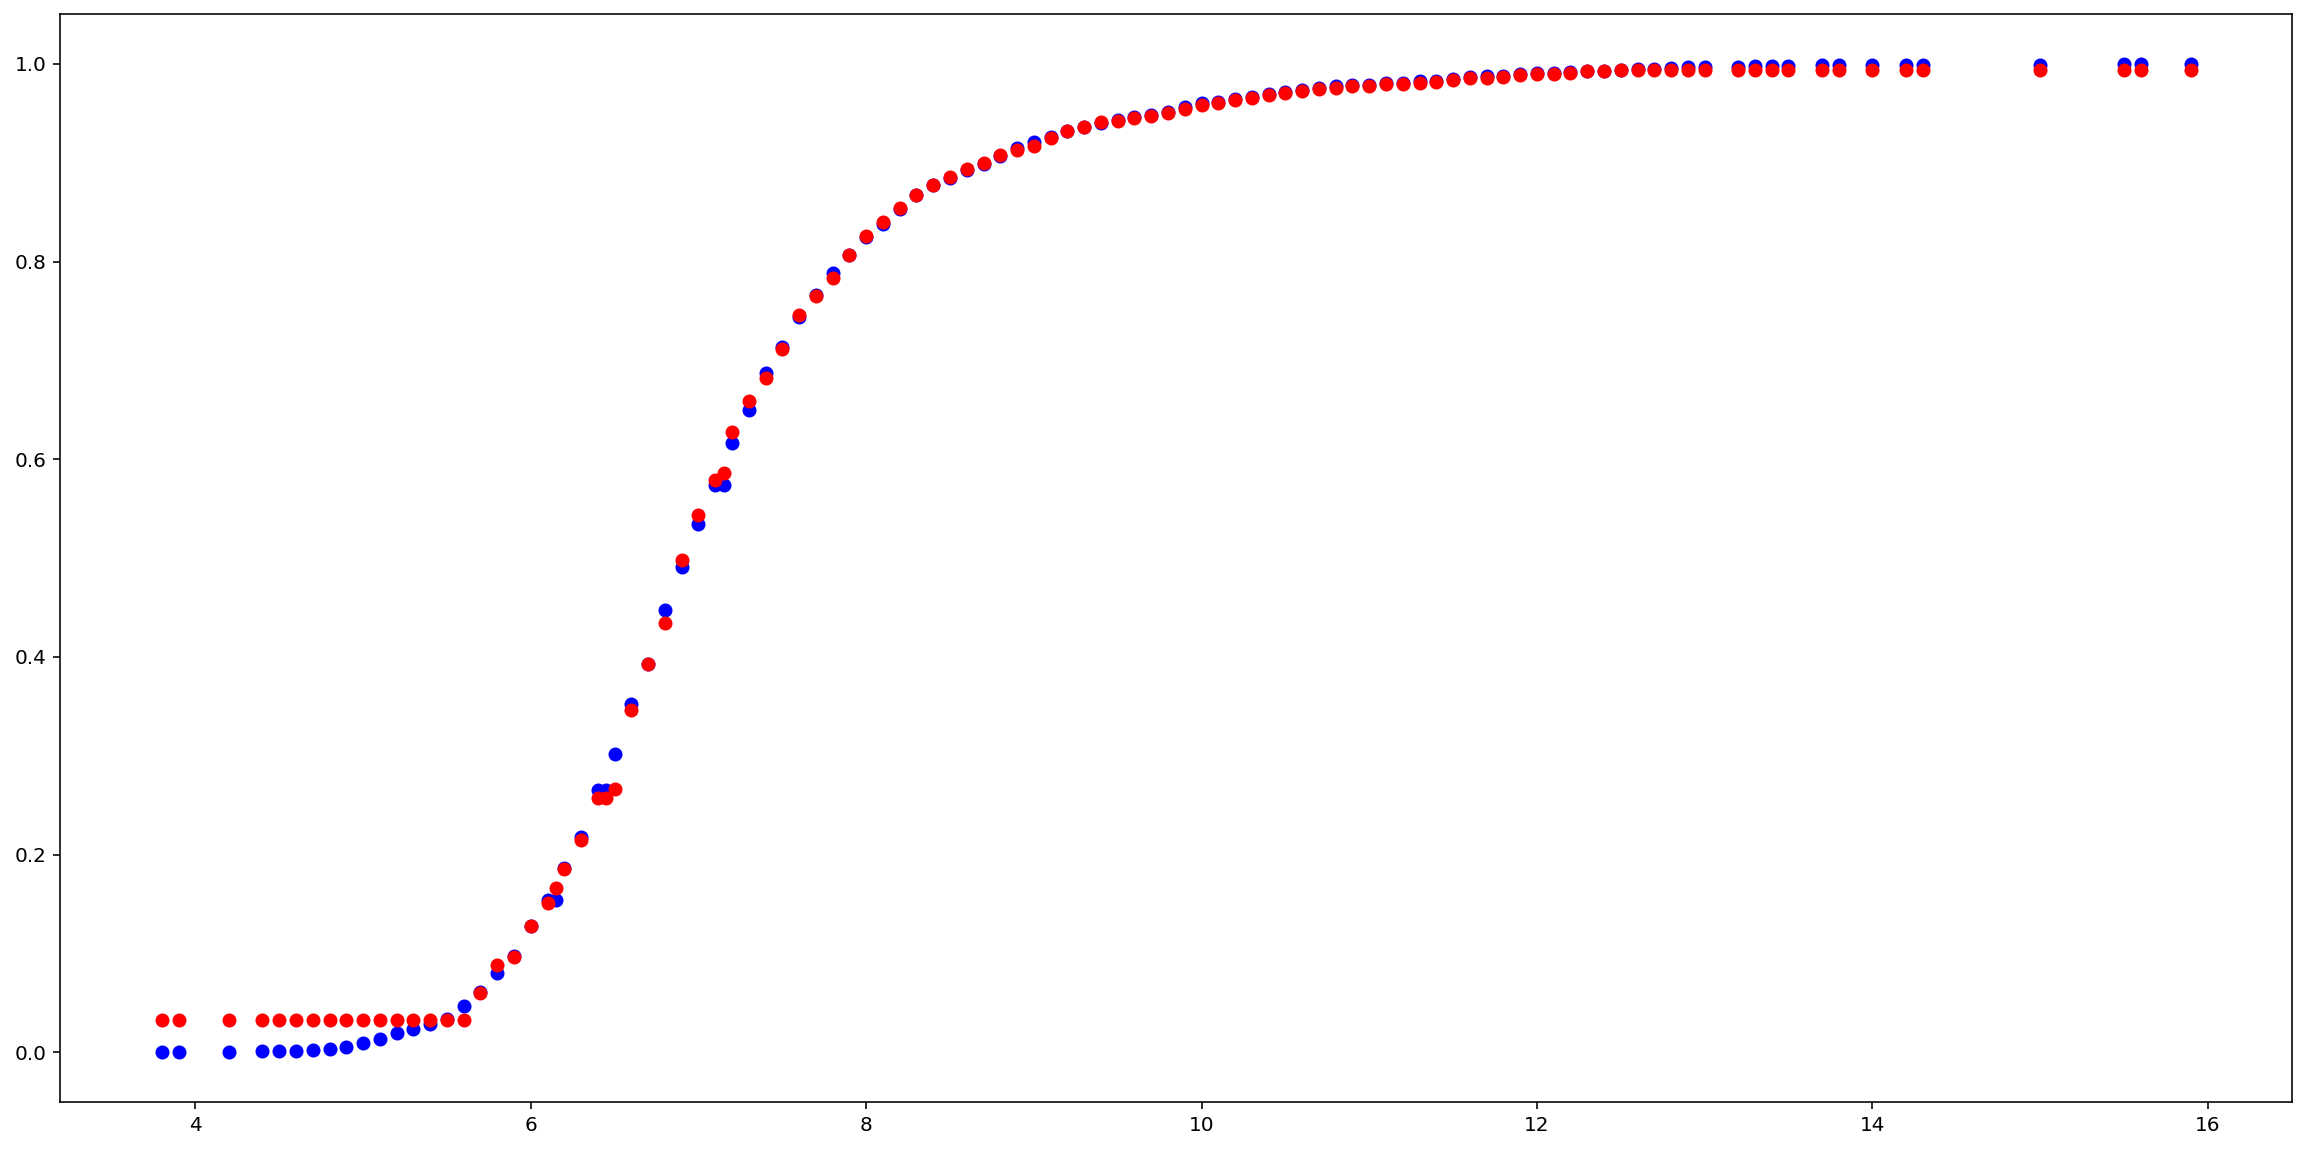

In [76]:
# 三层 pwl + 合适的 key points  + lattice
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

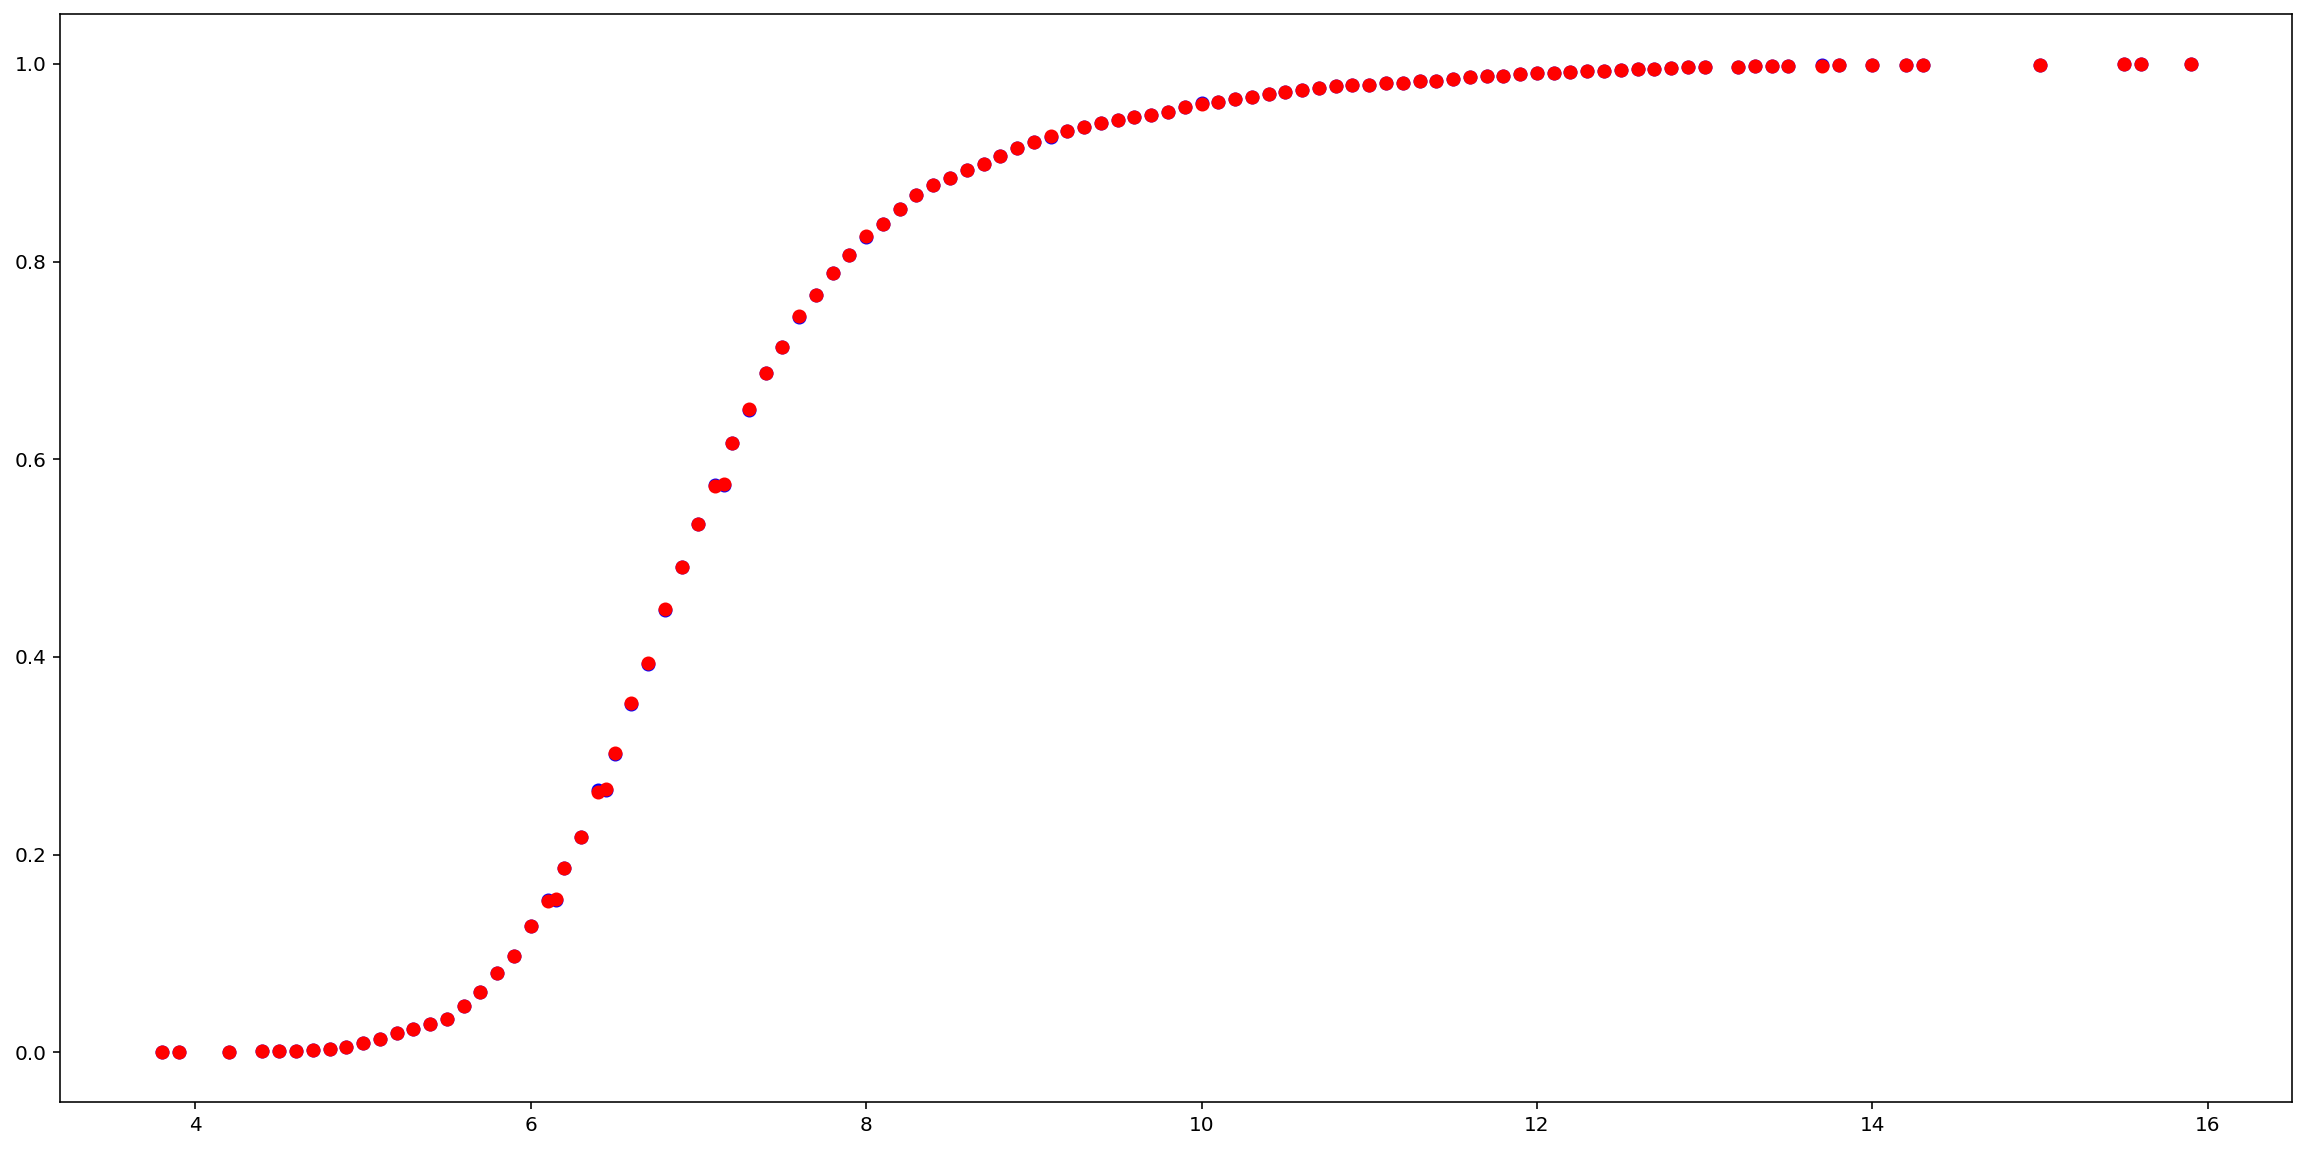

In [60]:
# 三层 pwl + 合适的 key points 拟合效果还是不错的
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

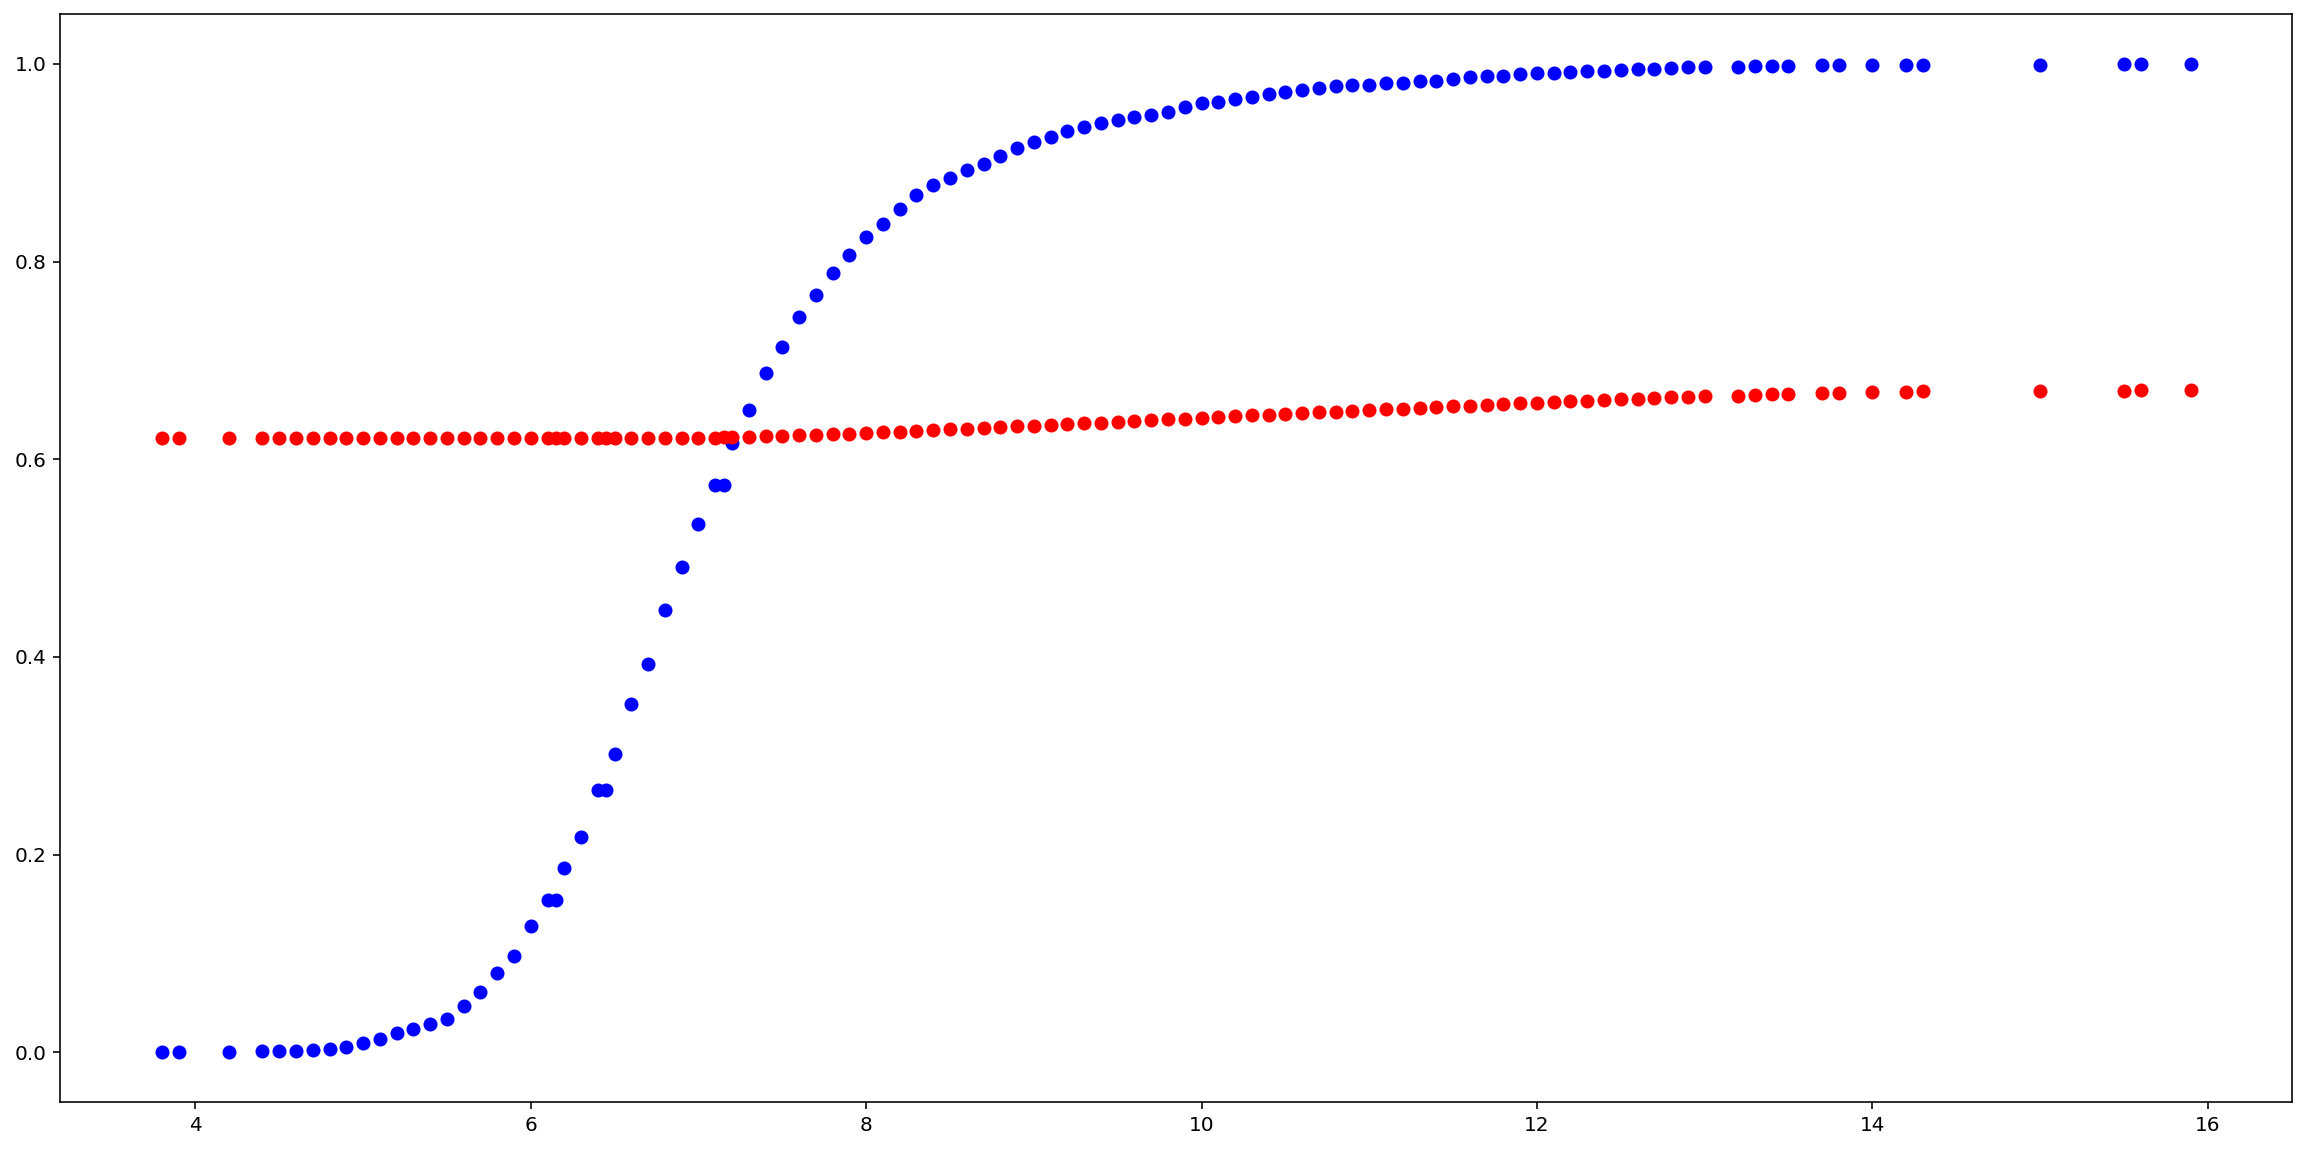

In [56]:
# 不同的key points 会影响模型的预测效果
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

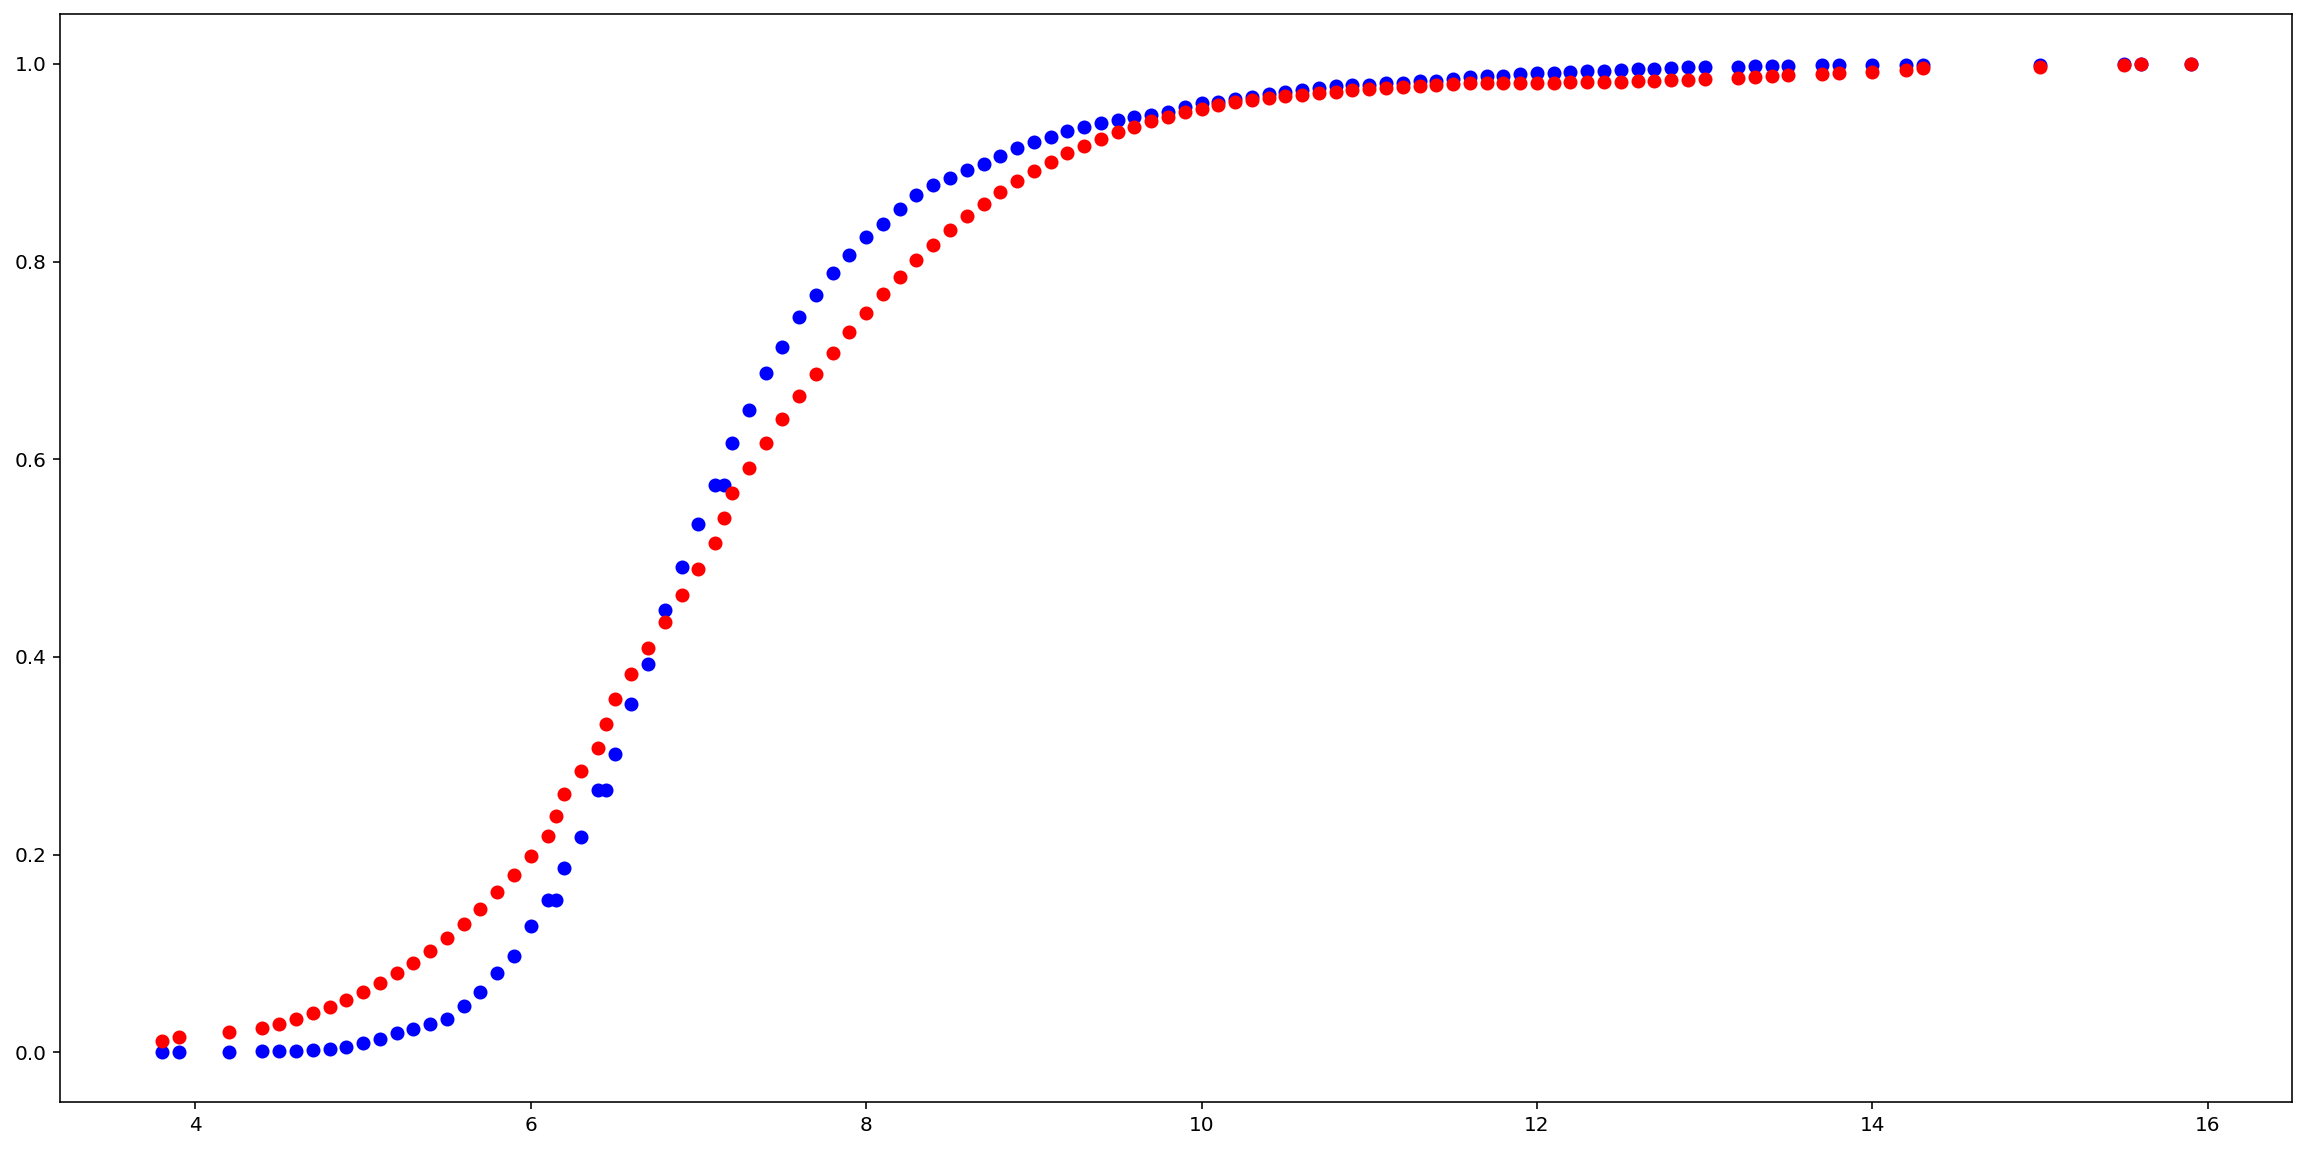

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

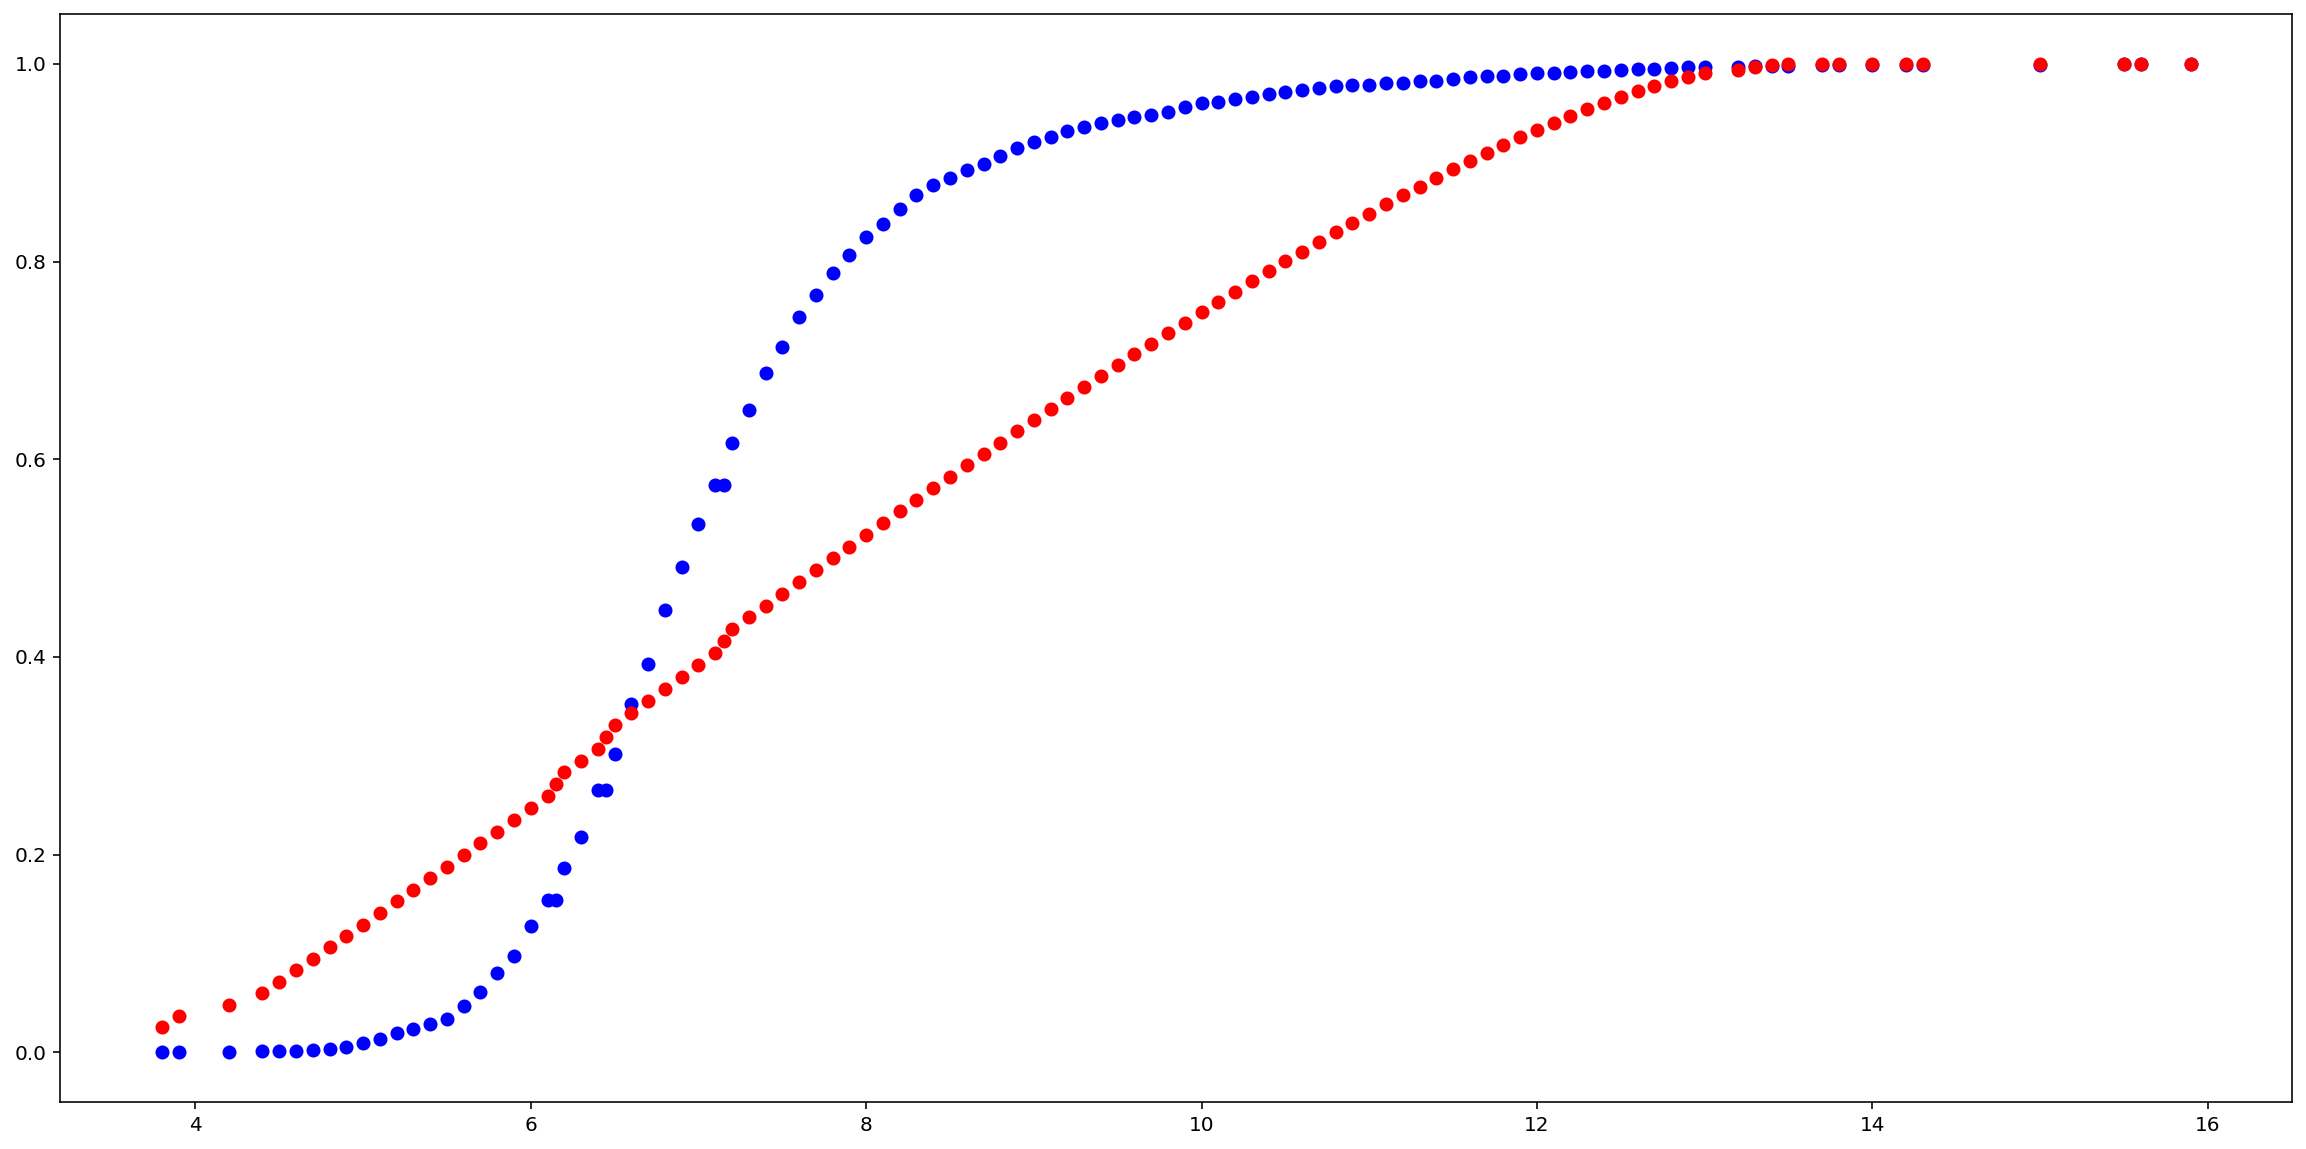

In [43]:
# epochs = 50, 1000 query
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

In [3]:
values = [v for v in unique_intervals.values()] * 2
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)

In [4]:
grid

array([[ 0. ,  0. ],
       [ 0. ,  1.9],
       [ 0. ,  3.8],
       ...,
       [16.9, 15.6],
       [16.9, 15.9],
       [16.9, 16.9]], dtype=float32)

In [5]:
m.inference(np.array([[0,0]]))

array([[0.0507793]], dtype=float32)

In [6]:
m.inference(np.array([[0,14.7]]))

array([[0.9989679]], dtype=float32)

In [7]:
m.inference(np.array([[2,14.7]]))

array([[0.9989679]], dtype=float32)

In [8]:
m.inference(np.array([[2,1]]))

array([[0.0502167]], dtype=float32)

In [9]:
train_X

array([[ 0. ,  3.8],
       [ 0. ,  4.2],
       [ 0. ,  4.2],
       ...,
       [ 0. , 15.6],
       [ 0. , 15.9],
       [ 0. , 15.9]], dtype=float32)

In [10]:
train_Y

array([[1.539172e-04],
       [6.156688e-04],
       [6.156688e-04],
       ...,
       [9.998461e-01],
       [1.000000e+00],
       [1.000000e+00]], dtype=float32)

In [11]:
pred = m.inference(grid)
#m.plotting(grid, pred)

In [12]:
# 增加边界点，看看对比的效果
# 增加epoch，看看误差和图形效果
# 增加query size，看看误差和效果

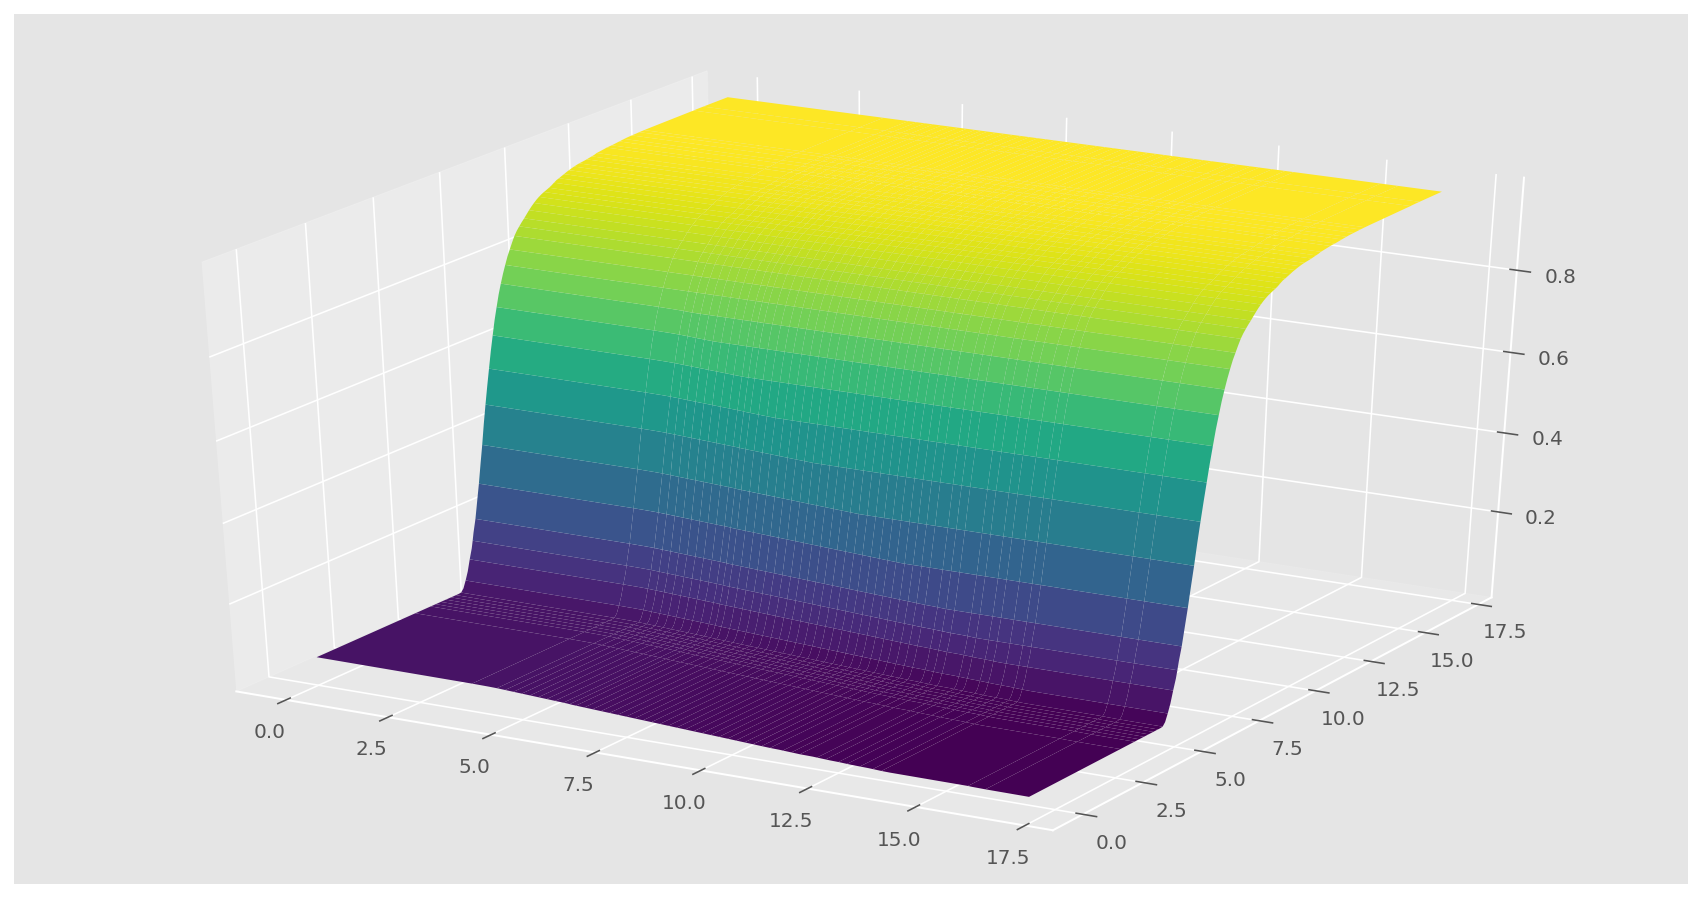

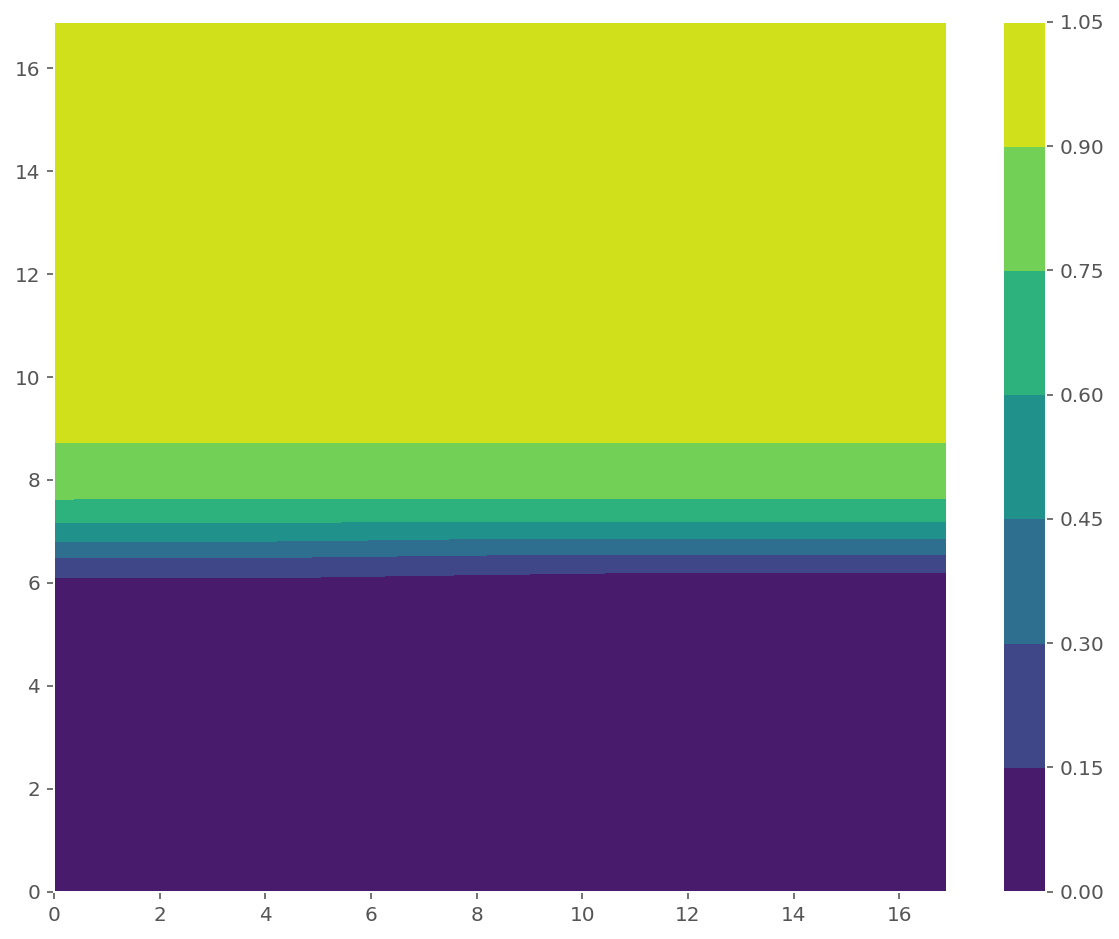

In [13]:
Xshape = len(np.unique(grid[:, 0]))
Yshape = len(np.unique(grid[:, 1]))
X = grid[:, 0].reshape(Xshape, Yshape)
Y = grid[:, 1].reshape(Xshape, Yshape)
Z = pred.reshape(Xshape, Yshape)

fig1 = plt.figure(figsize=(15, 8))
ax1 = plt.axes(projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap='viridis')
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # ??
cbar = fig2.colorbar(cs)  # 让colorbar细粒度更高一点
plt.show()